#### <center> Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

## <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам <br>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
#путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [3]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as fout:
        fout.write(str(answer))

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [4]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [5]:
X_sparse_10users.shape

(14061, 4913)

In [6]:
len(y_10users)

14061

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn_classifier = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [12]:
knn_cv = np.mean(cross_val_score(knn_classifier, X_train.todense(), y_train, n_jobs=-1, cv=skf))
knn_cv

0.559946836057815

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [13]:
knn_classifier.fit(X_train.todense(), y_train)
knn_acc = accuracy_score(y_valid, knn_classifier.predict(X_valid.todense()))

In [14]:
knn_acc

0.5897132021806115

In [15]:
write_answer_to_file("{} {}".format(round(knn_cv, 3), round(knn_acc, 3)),'4-1.txt')

In [16]:
!cat 4-1.txt

0.56 0.59

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
forest = RandomForestClassifier(n_estimators=100,  oob_score=True, random_state=17, n_jobs=-1)

In [36]:
forest.fit(X_train.todense(), y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=17)

In [30]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [38]:
forest.oob_score_

0.7174354805933754

In [37]:
forest_acc = accuracy_score(y_valid, forest.predict(X_valid.todense()))
forest_acc

0.7442521924626688

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [40]:
write_answer_to_file("{} {}".format(round(forest.oob_score_, 3), round(forest_acc, 3)), '4-2.txt')

In [41]:
!cat 4-2.txt

0.717 0.744

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [42]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [43]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [44]:
logit_cv = np.mean(cross_val_score(logit, X_train, y_train, cv=skf, n_jobs=-1))
logit_cv

0.7567560083555728

In [45]:
logit.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=17)

In [46]:
logit_acc = accuracy_score(y_valid, logit.predict(X_valid))
logit_acc

0.7885754918227068

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [47]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=17, 
                                            cv=skf, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 4.89 s, sys: 101 ms, total: 4.99 s
Wall time: 6.56 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

In [48]:
logit_c_values1

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [49]:
logit_mean_cv_scores1 = np.mean(logit_grid_searcher1.scores_[1], axis=0)
logit_mean_cv_scores1

array([0.31639964, 0.46596179, 0.54978646, 0.6467169 , 0.71225258,
       0.74700183, 0.75553674, 0.75299665, 0.7479169 , 0.73663886])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [50]:
np.max(logit_mean_cv_scores1), logit_grid_searcher1.Cs_[np.argmax(logit_mean_cv_scores1)]

(0.7555367439532366, 1.0)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

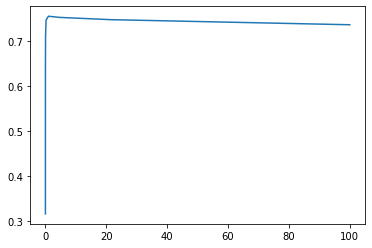

In [51]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [52]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs = logit_c_values2, multi_class='multinomial', random_state=17,
                                           cv=skf, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 4.63 s, sys: 79.9 ms, total: 4.71 s
Wall time: 17.7 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [53]:
logit_mean_cv_scores2 = np.mean(logit_grid_searcher2.scores_[1], axis=0)
logit_mean_cv_scores2

array([0.73379305, 0.75360619, 0.75553671, 0.75563831, 0.75553677,
       0.7547238 , 0.75513018, 0.75472377, 0.75380926, 0.75380926,
       0.75350447, 0.75269177, 0.75269177, 0.75198067, 0.75177742,
       0.75147257, 0.7515742 , 0.75126944, 0.75106622, 0.75086297])

In [54]:
logit_grid_searcher2.Cs_

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [55]:
np.max(logit_mean_cv_scores2), logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]

(0.7556383080213003, 1.1894736842105265)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

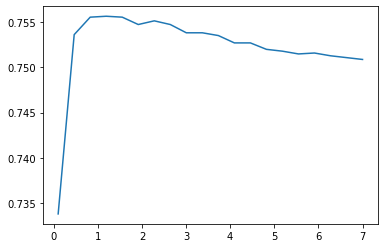

In [56]:
plt.plot(logit_c_values2, logit_mean_cv_scores2)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [57]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7871533538753259

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [58]:
write_answer_to_file("{} {}".format(round(np.max(logit_mean_cv_scores2), 3), 
                                    round(logit_cv_acc, 3)),
                     '4-3.txt')

In [59]:
!cat 4-3.txt

0.756 0.787

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [60]:
from sklearn.svm import LinearSVC

In [61]:
svm = LinearSVC(C=1, random_state=17)

In [62]:
svm_cv = np.mean(cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1))
svm_cv

0.7477134301211955

In [63]:
svm.fit(X_train, y_train)

LinearSVC(C=1, random_state=17)

In [64]:
svm_acc = accuracy_score(y_valid, svm.predict(X_valid))
svm_acc

0.7812277790945722

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [65]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid = svm_params1, cv = skf, n_jobs=-1, 
                                  return_train_score = True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 2.04 s, sys: 15 µs, total: 2.04 s
Wall time: 8.53 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [66]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.6940661681075818, {'C': 3333.3334000000004})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

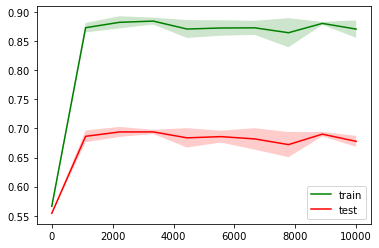

In [67]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [68]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, n_jobs=-1, 
                                  return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 600 ms, sys: 21.3 ms, total: 621 ms
Wall time: 11.8 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [69]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.7592958844096214, {'C': 0.10434482758620689})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

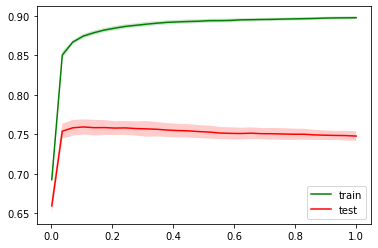

In [70]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [71]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid.todense()))
svm_cv_acc

0.7885754918227068

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [72]:
write_answer_to_file("{} {}".format(round(svm_grid_searcher2.best_score_, 3), 
                                    round(svm_cv_acc, 3)),
                     '4-4.txt')

In [73]:
!cat 4-4.txt

0.759 0.789

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [74]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as f:
        X = pickle.load(f)
    with open(path_to_y_pickle, 'rb') as f:
        y = pickle.load(f)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = test_size, stratify = y,
                                                          random_state = random_state)
    
    mean_cv = np.mean(cross_val_score(estimator, X_train, y_train, cv = cv, n_jobs =- 1))
    estimator.fit(X_train, y_train)
    accuracy = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return mean_cv, accuracy

**Убедитесь, что функция работает.**

In [75]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7592958844096214, 0.7885754918227068)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [76]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [77]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA,\
                                     'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA,\
                                     'y_10users_s{}_w{}.pkl'.format(session_length, window_size))                          
        print('session length ', session_length, 'window size ', window_size)
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

session length  15 window size  10
(0.8199545671927307, 0.8466461246740934)
session length  10 window size  10
(0.7592958844096214, 0.7885754918227068)
session length  15 window size  7
(0.8476529145325365, 0.8599634975941596)
session length  10 window size  7
(0.7958748150663458, 0.8154969304795089)
session length  7 window size  7
(0.7456614179975469, 0.7663846026215364)
session length  15 window size  5
(0.8676964413391276, 0.8763632053105738)
session length  10 window size  5
(0.8134335157366205, 0.8272878141299194)
session length  7 window size  5
(0.7716188864849326, 0.7822427690848743)
session length  5 window size  5
(0.7228432468652533, 0.7367235656709341)
CPU times: user 6.36 s, sys: 20.3 ms, total: 6.38 s
Wall time: 11.1 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [78]:
svm_cv, svm_acc = model_assessment(svm_grid_searcher2.best_estimator_, 
                                     os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'),
                                     os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), 
                                                  skf, random_state=17, test_size=0.3)
svm_cv, svm_acc

(0.8676964413391276, 0.8763632053105738)

In [81]:
write_answer_to_file("{} {}".format(round(svm_cv,3), round(svm_acc,3)), 
                     '4-5.txt')

In [82]:
!cat 4-5.txt

0.868 0.876

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [83]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA,\
                                     'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA,\
                                     'y_150users_s{}_w{}.pkl'.format(session_length, window_size))                          
        print('session length ', session_length, 'window size ', window_size)
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

session length  5 window size  5
(0.40920065286881613, 0.42268944371441086)
session length  7 window size  7
(0.4383786624622257, 0.45048881016452635)
session length  10 window size  10
(0.4649421871904747, 0.47856760570233053)
CPU times: user 3min 11s, sys: 217 ms, total: 3min 12s
Wall time: 6min 10s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [84]:
write_answer_to_file("{} {}".format(round(0.4649,3), round(0.4785,3)), '4-6.txt')

In [85]:
!cat 4-6.txt

0.465 0.478

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [86]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [87]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [88]:
%%time
c = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]
logit_cv_150users = LogisticRegressionCV(Cs = [c], multi_class='ovr', cv=skf, random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 10min 35s, sys: 9.63 s, total: 10min 44s
Wall time: 3min 11s


LogisticRegressionCV(Cs=[1.1894736842105265],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [89]:
cv_scores_by_user = logit_cv_150users.scores_
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, np.mean(cv_scores_by_user[user_id])))

User 1, CV score: 0.9948703512558256
User 2, CV score: 0.996966000437897
User 3, CV score: 0.9910022624670275
User 4, CV score: 0.9945992722571497
User 5, CV score: 0.9950684474471657
User 6, CV score: 0.9967574781312231
User 7, CV score: 0.9971223921679021
User 8, CV score: 0.9962883029412071
User 9, CV score: 0.995860832212526
User 10, CV score: 0.9921804134997342
User 11, CV score: 0.9966323647472187
User 12, CV score: 0.990616496199681
User 13, CV score: 0.9966740692085536
User 14, CV score: 0.9844546620374715
User 15, CV score: 0.9966010864012178
User 16, CV score: 0.9972058010905717
User 17, CV score: 0.986675424603547
User 18, CV score: 0.9976228457039191
User 19, CV score: 0.9963091551718746
User 20, CV score: 0.9930457810724302
User 21, CV score: 0.9948703512558256
User 22, CV score: 0.9951622824851688
User 23, CV score: 0.9960067978271976
User 24, CV score: 0.9968825915152273
User 25, CV score: 0.9970077048992317
User 26, CV score: 0.9982796909699415
User 27, CV score: 0.9982

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [90]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    cv_score = np.mean(cv_scores_by_user[user_id])
    part_label = (len(y_train_150) - class_distr[1])/len(y_train_150)
    diff = cv_score - part_label
    acc_diff_vs_constant.append(diff)
    print('User {}, diff: {}'.format(user_id, diff))

User 1, diff: 0.0076527686549268115
User 2, diff: 0.009748417836998202
User 3, diff: 0.0037846798661287373
User 4, diff: 0.007381689656250967
User 5, diff: 0.007850864846266958
User 6, diff: 0.009539895530324305
User 7, diff: 0.009904809567003348
User 8, diff: 0.009070720340308314
User 9, diff: 0.008643249611627213
User 10, diff: 0.004962830898835424
User 11, diff: 0.009414782146319967
User 12, diff: 0.003398913598782194
User 13, diff: 0.009456486607654857
User 14, diff: -0.002762920563427307
User 15, diff: 0.009383503800319049
User 16, diff: 0.009988218489672906
User 17, diff: -0.0005421579973517998
User 18, diff: 0.010405263103020368
User 19, diff: 0.009091572570975814
User 20, diff: 0.005828198471531487
User 21, diff: 0.0076527686549268115
User 22, diff: 0.007944699884270046
User 23, diff: 0.00878921522629883
User 24, diff: 0.009665008914328532
User 25, diff: 0.009790122298332982
User 26, diff: 0.011062108369042756
User 27, diff: 0.010999551677040587
User 28, diff: 0.009894383451669

In [91]:
num_better_than_default = (np.array(list(acc_diff_vs_constant)) > 0).sum()
num_better_than_default

142

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [92]:
num_better_than_default/150

0.9466666666666667

In [93]:
write_answer_to_file(round(num_better_than_default/150, 3), 
                     'answer4_7.txt')

In [94]:
!cat answer4_7.txt

0.947

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [95]:
y_binary_128 = np.array([1 if i == 128 else 0 for i in y_150users])

In [96]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [97]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, 
                                              train_sizes=train_sizes, cv=skf, n_jobs=-1)

CPU times: user 257 ms, sys: 52.2 ms, total: 309 ms
Wall time: 2.47 s


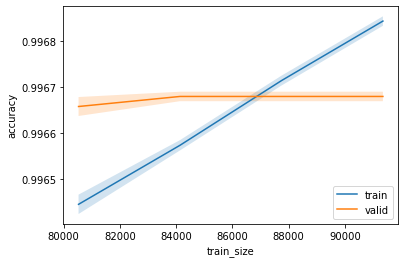

In [98]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**